In [3]:
import os 
import pandas as pd 
import spacy 
import torch
from torch.nn.utils.rnn import pad_sequence  
from torch.utils.data import DataLoader, Dataset
from PIL import Image  
import torchvision.transforms as transforms
from tqdm import tqdm
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import sys
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import statistics
import torchvision.models as models

torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
spacy_eng = spacy.load("en_core_web_sm")

def getNumberOfParameter(model):
    print('Number of trainable params: ', sum(p.numel() for p in model.parameters() if p.requires_grad))
    print('Total params: ', sum(p.numel() for p in model.parameters()))

class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]


In [5]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, choose_file, isTrain, transform=None, freq_threshold=2):
        self.root_dir = root_dir
        
        self.df = pd.read_csv(captions_file, sep='\t', names=['image', 'caption'])
        self.df['image'] = self.df["image"].str.split('#', 1, expand=True)[0]
        
        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.df["caption"].tolist())
        
        #self.df = self.df.groupby('image').first().reset_index()
        
        self.choose_df = pd.read_csv(choose_file, names=['image'])
        if isTrain:
            validation_df = pd.read_csv('/kaggle/input/flikerdata/Flickr8K/Flickr8k_text/Flickr_8k.valImages.txt',
                                    names=['image'])
            self.choose_df = pd.concat([self.choose_df, validation_df]).reset_index()
            
        self.df = self.df.loc[self.df['image'].isin(self.choose_df['image'].values)].reset_index(drop=True)
        
        self.transform = transform

        # Get img, caption columns
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.new('RGB', (RESIZE,RESIZE))
        try:
            img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")
        except:
            print(img_id)

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)



In [6]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)
        
        return imgs, targets

In [7]:
def get_loader(
    root_folder,
    annotation_file,
    choose_file,
    transform,
    batch_size=32,
    num_workers=8,
    shuffle=True,
    pin_memory=True,
    isTrain=True
):
    dataset = FlickrDataset(root_folder, annotation_file, choose_file, transform=transform, isTrain=isTrain)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return loader, dataset

In [8]:
class EncoderCNN(nn.Module):
    def __init__(self, train_CNN, encoded_image_size=14):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.encoded_image_size = encoded_image_size
        
        resnet = models.resnet18(pretrained=True)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))
        
        # Fine tune
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Only train last 2 layers of resnet if at all required
        if train_CNN:
            for c in list(self.resnet.children())[-2:]:
                for p in c.parameters():
                    p.requires_grad = trainCNN
        

    def forward(self, images):
        features = self.resnet(images) 
        features = self.adaptive_pool(features) # batch, 512, encoded_image_size, encoded_image_size
        features = features.permute(0, 2, 3, 1) # batch, encoded_image_size, encoded_image_size, 512
        return features
            
            

In [9]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1) 

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)
        att2 = self.decoder_att(decoder_hidden)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)

        return attention_weighted_encoding, alpha


In [10]:
class DecoderRNN(nn.Module):
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim, dropout):
        """
        decoder_dim is hidden_size for lstm cell
        """
        super(DecoderRNN, self).__init__()
        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout
        
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)  
        
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()  # initialize some layers with the uniform distribution
        
    def init_weights(self):
        """
        Initializes some parameters with values from the uniform distribution, for easier convergence.
        """
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)
    
    def init_hidden_state(self, encoder_out):
        """
        Creates the initial hidden and cell states for the decoder's LSTM based on the encoded images.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :return: hidden state, cell state
        """
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions):
        """
        :param encoder_out: encoded images, a tensor of dimension (batch_size, enc_image_size, enc_image_size, encoder_dim)
        :param encoded_captions: encoded captions, a tensor of dimension (batch_size, max_caption_length)
        :return: scores for vocabulary, sorted encoded captions, decode lengths, weights, sort indices
        """
        
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size
        
        # Flatten image
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)
        
        # Embedding
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)
        
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        
        decode_length = encoded_captions.size(1)-1
        
        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, decode_length, vocab_size).to(device)
        alphas = torch.zeros(batch_size, decode_length, num_pixels).to(device)
        
        for t in range(decode_length):
            
            attention_weighted_encoding, alpha = self.attention(encoder_out, h)
            gate = self.sigmoid(self.f_beta(h))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
                        
            h, c = self.decode_step(torch.cat([embeddings[:, t, :], attention_weighted_encoding], dim=1), (h, c))  #(batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:, t, :] = preds
            alphas[:, t, :] = alpha

        return predictions, alphas


In [11]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step

In [12]:
class CNNtoRNN(nn.Module):
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=512, dropout=0.5, train_CNN=False):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(train_CNN=train_CNN)
        self.decoderRNN = DecoderRNN(attention_dim, embed_dim, decoder_dim, vocab_size,
                                     encoder_dim=encoder_dim, dropout=dropout)

    def forward(self, images, captions):
        encoder_out = self.encoderCNN(images)
        outputs, alphas = self.decoderRNN(encoder_out, captions)
        return outputs, alphas

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = [1]
    
        with torch.no_grad():
            encoder_out = self.encoderCNN(image)
            
            batch_size = encoder_out.size(0)
            encoder_dim = encoder_out.size(-1)
            vocab_size = self.decoderRNN.vocab_size
            
            encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
            num_pixels = encoder_out.size(1)
            
            # initially start with sos as a predicted word
            predicted = torch.tensor([vocabulary.stoi["<SOS>"]]).to(device)
            h, c = self.decoderRNN.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
            
            for t in range(max_length):
                embeddings = self.decoderRNN.embedding(predicted)  # (1, embed_dim)
                
                attention_weighted_encoding, alpha = self.decoderRNN.attention(encoder_out, h)
                gate = self.decoderRNN.sigmoid(self.decoderRNN.f_beta(h))  # gating scalar, (batch_size_t, encoder_dim)
                attention_weighted_encoding = gate * attention_weighted_encoding
                
                h, c = self.decoderRNN.decode_step(torch.cat([embeddings, attention_weighted_encoding], dim=1), (h, c))  #(batch_size_t, decoder_dim)
                preds = self.decoderRNN.fc(self.decoderRNN.dropout(h))  # (batch_size_t, vocab_size)
                    
                predicted = preds.argmax(1)
                result_caption.append(predicted.item())
                
                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break
            
            return [vocabulary.itos[idx] for idx in result_caption]
            

In [13]:
RESIZE = 356
CROP = 299

In [14]:
# get the losses for vizualization
losses = list()
val_losses = list()
# Train the model
batch_size=32
transform = transforms.Compose(
    [
        transforms.Resize((RESIZE, RESIZE)),
        transforms.RandomCrop((CROP, CROP)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
train_loader, dataset = get_loader(
    '/kaggle/input/flikerdata/Flickr8K/Flicker8k_Images',
    '/kaggle/input/flikerdata/Flickr8K/Flickr8k_text/Flickr8k.token.txt',
    '/kaggle/input/flikerdata/Flickr8K/Flickr8k_text/Flickr_8k.trainImages.txt',
    transform=transform,
    num_workers=8,
    batch_size=batch_size,
    shuffle=True,
    isTrain=True
)

val_loader, val_dataset = get_loader(
    '/kaggle/input/flikerdata/Flickr8K/Flicker8k_Images',
    '/kaggle/input/flikerdata/Flickr8K/Flickr8k_text/Flickr8k.token.txt',
    '/kaggle/input/flikerdata/Flickr8K/Flickr8k_text/Flickr_8k.valImages.txt',
    transform=transform,
    num_workers=8,
    batch_size=batch_size,
    shuffle=True,
    isTrain=True
)
# Hyperparameters
attention_dim = 700
embed_dim = 700
decoder_dim = 700
dropout = 0.5
vocab_size = len(dataset.vocab)
learning_rate = 1e-03
num_epochs = 10
load_model = False
save_model = True
train_CNN = False
alpha_c = 1

def train():
    
    step = 0

    # initialize model, loss etc
    model = CNNtoRNN(attention_dim, embed_dim, decoder_dim, vocab_size, train_CNN=train_CNN, dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()

    for epoch in range(num_epochs):
        
        loss = 400
        if save_model:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "step": step,
            }
            save_checkpoint(checkpoint)
            torch.save(model.state_dict(), 'puremodel.pth.tar')

        for idx, (imgs, captions) in tqdm(
            enumerate(train_loader), total=len(train_loader), leave=False
        ):

            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs, alphas = model(imgs, captions.permute(1, 0))
            loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.permute(1, 0)[:, 1:].reshape(-1))

            #writer.add_scalar("Training loss", loss.item(), global_step=step)
            step += 1

            optimizer.zero_grad()
            loss.backward(loss)
            
            # Add doubly stochastic attention regularization
            #loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()
            
            optimizer.step()
            
        print('Epoch {} completed with loss {}'.format(epoch+1, loss))\
        
        
        
        model.eval()

        for idx, (imgs, captions) in tqdm(
            enumerate(val_loader), total=len(val_loader), leave=False
        ):

            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs, alphas = model(imgs, captions.permute(1, 0))
            loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.permute(1, 0)[:, 1:].reshape(-1))
               
            
        print('Epoch val {} completed with loss {}'.format(epoch+1, loss))
    
train()

/tmp/ipykernel_29/3989402672.py:6: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  self.df['image'] = self.df["image"].str.split('#', 1, expand=True)[0]
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/tmp/ipykernel_29/3989402672.py:6: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  self.df['image'] = self.df["image"].str.split('#', 1, expand=True)[0]
/opt/conda/lib/python3.10/site-packages/tor

=> Saving checkpoint


Epoch 1 completed with loss 2.9218125343322754


Epoch val 1 completed with loss 2.2139976024627686
=> Saving checkpoint


Epoch 2 completed with loss 2.3945796489715576


Epoch val 2 completed with loss 1.9848991632461548
=> Saving checkpoint


Epoch 3 completed with loss 2.5320839881896973


Epoch val 3 completed with loss 2.1491005420684814
=> Saving checkpoint


Epoch 4 completed with loss 1.9835455417633057


Epoch val 4 completed with loss 1.7549725770950317
=> Saving checkpoint


Epoch 5 completed with loss 2.1149179935455322


Epoch val 5 completed with loss 1.6537843942642212
=> Saving checkpoint


Epoch 6 completed with loss 1.6171295642852783


Epoch val 6 completed with loss 1.3266181945800781
=> Saving checkpoint


Epoch 7 completed with loss 1.591558814048767


Epoch val 7 completed with loss 1.284853458404541
=> Saving checkpoint


Epoch 8 completed with loss 1.4806932210922241


Epoch val 8 completed with loss 1.0449742078781128
=> Saving checkpoint


Epoch 9 completed with loss 1.3564417362213135


Epoch val 9 completed with loss 0.8780141472816467
=> Saving checkpoint


Epoch 10 completed with loss 1.067988634109497


Epoch val 10 completed with loss 1.0280450582504272


In [15]:
test_loader, test_dataset = get_loader(
    '/kaggle/input/flikerdata/Flickr8K/Flicker8k_Images',
    '/kaggle/input/flikerdata/Flickr8K/Flickr8k_text/Flickr8k.token.txt',
    '/kaggle/input/flikerdata/Flickr8K/Flickr8k_text/Flickr_8k.testImages.txt',
    transform=transform,
    num_workers=8,
    shuffle=False,
    isTrain=False
)

model = CNNtoRNN(attention_dim, embed_dim, decoder_dim, vocab_size, train_CNN=train_CNN, dropout=dropout).to(device)
model.load_state_dict(torch.load("./my_checkpoint.pth.tar")['state_dict'])
#model.load_state_dict(torch.load("../input/flickr8k/my_checkpoint.pth.tar")['state_dict'])
model.eval()

predicted_captions = []
i = 0
for idx, (imgs, captions) in tqdm(
            enumerate(test_loader), total=len(test_loader), leave=False
        ):
    for k in range(imgs.shape[0]):
        img = imgs[k].unsqueeze(0)
        real_caption = [dataset.vocab.itos[j.item()] for j in captions[:, k]]
        predicted_captions.append([model.caption_image(img.to(device), dataset.vocab), real_caption])
        i += 1


/tmp/ipykernel_29/3989402672.py:6: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  self.df['image'] = self.df["image"].str.split('#', 1, expand=True)[0]
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_util

In [16]:
# !pip install nltk

In [17]:
# import nltk 
# nltk.download('wordnet')

In [18]:
# from nltk.translate import meteor_score

# list_real =

In [19]:
i = 0
references_corpus = []
candidate_corpus = []
for e in predicted_captions:
    if i % 5 == 0:
        if i < 21:
            print('Image name: {}'.format(test_dataset.df['image'][i]))
            print('Real caption: ', [ e for e in predicted_captions[i][1] if e != '<PAD>'])
            print('Predicted caption: ', [ e for e in predicted_captions[i][0] if e != '<PAD>'])
            print('\n')
        references_corpus.append([[ e for e in predicted_captions[i][1] if e != '<PAD>']])
        candidate_corpus.append([ e for e in predicted_captions[i][0] if e != '<PAD>'])
        
    else:
        references_corpus[i//5].append([ e for e in predicted_captions[i][1] if e != '<PAD>'])
        
    i+=1

from torchtext.data.metrics import bleu_score
print(bleu_score(candidate_corpus, references_corpus))


Image name: 1056338697_4f7d7ce270.jpg
Real caption:  ['<SOS>', 'a', 'blond', 'woman', 'in', 'a', 'blue', 'shirt', 'appears', 'to', 'wait', 'for', 'a', 'ride', '.', '<EOS>']
Predicted caption:  ['<SOS>', 'a', 'woman', 'with', 'a', 'blue', 'mohawk', 'is', 'looking', 'to', 'the', 'camera', '.', '<EOS>']


Image name: 106490881_5a2dd9b7bd.jpg
Real caption:  ['<SOS>', 'a', 'boy', 'in', 'his', 'blue', 'swim', 'shorts', 'at', 'the', 'beach', '.', '<EOS>']
Predicted caption:  ['<SOS>', 'a', 'young', 'boy', 'wearing', 'a', 'blue', 'tank', 'top', 'and', 'shorts', 'is', 'jumping', 'in', 'the', 'sand', '.', '<EOS>']


Image name: 1082379191_ec1e53f996.jpg
Real caption:  ['<SOS>', 'a', 'lady', 'and', 'a', 'man', 'with', 'no', 'shirt', 'sit', 'on', 'a', 'dock', '.', '<EOS>']
Predicted caption:  ['<SOS>', 'a', 'shirtless', 'man', 'sits', 'on', 'a', 'boat', 'and', 'looks', 'at', 'the', 'ground', '.', '<EOS>']


Image name: 1084040636_97d9633581.jpg
Real caption:  ['<SOS>', 'a', 'closeup', 'of', 'a', '

In [20]:
# getNumberOfParameter(model)

In [21]:
hypothesis1 = ['It', 'is', 'a', 'guide', 'to', 'action', 'which', 'ensures', 'that', 'the', 'military', 'always', 'obeys', 'the', 'commands', 'of', 'the', 'party']

In [22]:
reference1 = ['It', 'is', 'a', 'guide', 'to', 'action', 'that', 'ensures', 'that', 'the', 'military', 'will', 'forever', 'heed', 'Party', 'commands']

In [23]:
# round(single_meteor_score(reference1, hypothesis1),4)

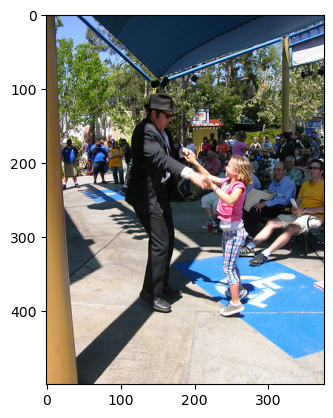

a group of people are standing in a circle on a bench in front of a white building . 


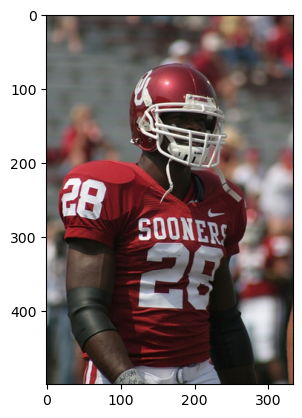

a football player in a red sooners jersey <UNK> out of a football . 


In [30]:
import matplotlib.pyplot as plt

base_path = '/kaggle/input/flikerdata/Flickr8K/Flicker8k_Images/'
def showAndCaptionImage(img, model):
    
    img = Image.open(base_path + img).convert("RGB")
    plt.imshow(img)
    plt.show()
    img = transform(img)
    caption = model.caption_image(img.unsqueeze(0).to(device), dataset.vocab)[1:-1]
    captionStr = ""
    for e in caption:
        captionStr += e + " "
    print(captionStr)

subjective_images = ['2415803492_56a673dc25.jpg', '241347760_d44c8d3a01.jpg']
for image in subjective_images:
    showAndCaptionImage(image, model)